In [1]:
!pip install cpi

# Import Libraries

The following libraries will be used for data loading, cleaning, and visualizations

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import requests
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import cpi
from scipy.stats import pearsonr, ttest_ind

# Helper Functions

The exchange_rate_data function generates a DataFrame containing historical exchange rates for different currencies, and the convert_currency function calculates the converted amount based on a specified amount, currency, year, and the provided exchange rates DataFrame.

The dataset (CSV format) can be obtained via the link:

https://drugdatabase.info/revenues/.

https://drugdatabase.info/selected-pharmaceutical-company-financials/.



In [3]:
import pandas as pd

def exchange_rate_data():
    """
    Function to create a DataFrame with exchange rate data for different currencies over multiple years.

    Returns:
    - exchange_rates_df: DataFrame containing exchange rates.
    """
    exchange_rate_data = {
        'Year': [2015, 2016, 2017],
        'EUR': [0.901, 0.903, 0.885],  # Exchange rates for Euro
        'USD': [1, 1, 1],  # Exchange rates for US Dollar
        'CHF': [0.962, 0.985, 0.985],  # Exchange rates for Swiss Franc
        'DKK': [6.728, 6.732, 6.603],  # Exchange rates for Danish Krone
        'USA': [1, 1, 1],  # Exchange rates for USA (assuming it's another representation for USD)
        'JPY': [121.044, 108.793, 112.166],  # Exchange rates for Japanese Yen
        'YEN': [121.044, 108.793, 112.166],  # Duplicate representation for Japanese Yen
        'GBP': [0.655, 0.741, 0.777]  # Exchange rates for British Pound
    }
    exchange_rates_df = pd.DataFrame(exchange_rate_data)
    
    return exchange_rates_df

def convert_currency(amount, currency, year, exchange_rates_df):
    """
    Function to convert the specified amount from one currency to another based on the provided exchange rates.

    Parameters:
    - amount: The amount to convert.
    - currency: The currency (source or target) for which to get the exchange rate.
    - year: The year for which to get the exchange rate.
    - exchange_rates_df: DataFrame containing exchange rates.

    Returns:
    - The converted amount.
    """
    try:
        # Get exchange rate for the specified currency and year
        rate = exchange_rates_df.loc[(exchange_rates_df['Year'] == year), currency].values[0]
        
        # Perform the currency conversion
        converted_amount = amount / rate
        
        return converted_amount
    except:
        return None

The function is intended for auditing the inflation-adjusted value of the dollar across all years, normalizing the data for meaningful comparisons with the reference year being 2023

In [4]:
# The inflation_adjusting function adjusts the amount based on the CPI data.
def inflation_adjusting(amount, from_year, to_year):
    """
    Adjust the specified amount for inflation from one year to another using Consumer Price Index (CPI).

    Parameters:
    - amount: The amount to be adjusted.
    - from_year: The initial year of the amount.
    - to_year: The target year for inflation adjustment.

    Returns:
    - adjusted_amount: The amount adjusted for inflation.
    """
    try:
        adjusted_amount = cpi.inflate(amount, from_year, to_year)
        return adjusted_amount
    except:
        return None


The function "extract_value" utilizes regular expressions to parse strings representing monetary amounts and returns the extracted numerical value as a float, handling NaN inputs appropriately.

In [5]:
def extract_value(money_string):
    """
    Extract numerical values from strings representing monetary amounts.

    Parameters:
    - money_string: The string containing the monetary amount.

    Returns:
    - The numerical value extracted from the string.
    """
    if pd.isna(money_string):  # Check if the input is NaN
        return np.nan  # Return NaN if the input is NaN
        
    # Use regular expression to find all integer or float values in the string
    digits = re.findall(r"\d+\.\d+|\d+", money_string)
    number = "".join(digits) # Join the digits into a single string
    # Convert the string representation of the number to a float
    number = float(number)

    return number  # Return the extracted numerical value

# Loading, Cleaning, and Manipulating the datas


This code loads pharmaceutical sales and financial data from CSV files, preprocesses the data by dropping unnecessary columns, converting data types, filtering out rows with irrelevant information, and renaming columns for clarity. Additionally, it defines a helper function to extract numerical values from strings.

In [6]:
# Load the datasets
sales_df = pd.read_csv("Sales, by year, for certain drugs and cell therapies - Drugs.csv")

# Drop the "2023" column which is empty
sales_df = sales_df.drop("2023", axis=1)

# Convert the 'Drug' column to string type
sales_df['Drug'] = sales_df['Drug'].astype(str)

# Filter out rows that contain parentheses, for they are subitems of a drug sale and are redundancy.
sales_df = sales_df[~sales_df['Drug'].str.contains('\(.*\)')]

# Load financial data
revenue2017_df = pd.read_csv("Selected Pharmaceutical Company Financials (Summary) - 2017.csv")
revenue2016_df = pd.read_csv("Selected Pharmaceutical Company Financials (Summary) - 2016.csv")
revenue2015_df = pd.read_csv("Selected Pharmaceutical Company Financials (Summary) - 2015.csv")

# Rename columns and drop the first row for financial data
for df in [revenue2017_df, revenue2016_df, revenue2015_df]:
    df.rename(columns={"Unnamed: 0": "Country", "Unnamed: 1": "Currency"}, inplace=True)
    df.drop(0, inplace=True)

year_list=['2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014',
       '2013', '2012', '2011', '2010', '2009', '2008', '2007', '2006', '2005',
       '2004', '2003', '2002', '2001', '2000', '1999', '1998', '1997', '1996',
       '1995', '1994', '1993', '1992', '1991', '1990']

This code will excecute the numeric value in try-except mode and detect the aberrant values in the sales and revenues datasets.

In [7]:
# Detect the exceptions in numeric value conversion using try-except mode:
for col in year_list:
    try:
        sales_df[col].map(extract_value)       
    except:
        print(col)

# The outputs "2017" and "2016" are the exception columns. We will determine the abnormal values in these columns.
for col in ["2017","2016"]:
    for i in sales_df[col].unique():
        try:
            extract_value(i)
        except:
            print(i, col)

# In the revenue Dataframes, only columns from "2017/2016/2015 Revenue" to "CoG, overhead, marketing and R&D" (columns 4 to 11) needs to be converted
# As the datasheet in each year has different year name, let's use iloc for a quick check

for df in [revenue2017_df, revenue2016_df, revenue2015_df]:
    for col_num in range(4,12):
        try:
            df.iloc[:,col_num].map(extract_value)           
        except:
            print([revenue2017_df, revenue2016_df, revenue2015_df].index(df),col_num)

2017
2016
not reported 2017
de minimus 2016
0 4


This code further cleans the datasets by replacing specific string values with NaNs, converting sales and financial data values to numeric format, and renaming columns for clarity. It also removes rows from the sales dataset where all values in specific columns corresponding to the years in the sales_year_list are missing

In [8]:
# More cleaning based on the abberant output above.
sales_df["2017"].replace({"not reported":np.nan},inplace=True)
sales_df["2016"].replace({"de minimus":np.nan},inplace=True)

# And the output "0 4" above indicates the abberant value is in the column 4 of revenue2017_df
revenue2017_df.iloc[:,4].unique() # "Not reported" is seen!
revenue2017_df.iloc[:,4].replace({"Not reported":np.nan},inplace=True)

# Convert the sale values to numeric first.
sales_df[year_list] = sales_df[year_list].applymap(lambda x: extract_value(x) if isinstance(x, str) else x)

# Converstion for revenue2017_df, revenue2016_df, revenue2015_df.

col_2017 =['2017 Revenue', '2017 Cost of Goods', '2017 Marketing and Overhead', '2017 R&D', 'R&D as share of revenue',
       'Marketing & Overhead as a share of revenue','Cost of goods as a percentage', 'CoG, overhead, marketing and R&D']

col_2016 =['2016 Revenue', '2016 Cost of Goods', '2016 Marketing and Overhead', '2016 R&D', 'R&D as share of revenue',
       'Marketing & Overhead as a share of revenue','Cost of goods as a percentage', 'CoG, overhead, marketing and R&D']

col_2015 =['2015 Revenue', '2015 Cost of Goods', '2015 Marketing and Overhead', '2015 R&D', 'R&D as share of revenue',
       'Marketing & Overhead as a share of revenue','Cost of goods as a percentage', 'CoG, overhead, marketing and R&D']

revenue2017_df[col_2017]= revenue2017_df[col_2017].applymap(extract_value)
revenue2016_df[col_2016]= revenue2016_df[col_2016].applymap(extract_value)
revenue2015_df[col_2015]= revenue2015_df[col_2015].applymap(extract_value)
        
# Columns 8 to 11 in revenue2017_df, revenue2016_df and revenue2015_df were percentage values before, so "%" should be added to the column name
for df in [revenue2017_df,revenue2016_df,revenue2015_df]:
    for col in col_2017[4:8]: # all the same in each dataframe, just use col_2017
        new_col= col+" (%)"
        df.rename({col:new_col},inplace=True,axis=1)

# List of all the years in sales_df
sales_year_list=["2020","2019","2018","2017","2016","2015","2014","2013","2012","2011","2010"]

# Removes rows from sales_df where all the values in the columns corresponding to the years specified in sales_year_list are missing
sales_df=sales_df.dropna(subset=sales_year_list,how="all")
sales_df.head()

,Drug,INN,Date first registered by US FDA,Company or Companies,Indication,US FDA Orphan indications (23-10-2020) (designations),Currency,Years since 1st US FDA approval,Cumulative revenue (in millions),2022,...,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990
0,Kyprolis,carfilzomib,2012-07-20,A general,Cancer: Multiple Myeloma,1.0,USD,11.2,"$1,960",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Humira,adalimumab,2002-12-31,Abbvie,"Rheumatoid arthritis (initial indication, now ...",9.0,USD,20.5,"$192,687",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Viekira,dasabuvir sodium; ombitasvir; paritaprevir; ri...,2014-12-19,Abbvie,HCV,1.0,USD,8.8,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Ampyra,dalfampridine,2010-01-22,Acorda Therapeutics,MS,2.0,USD,13.6,"$3,207",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Soliris,eculizumab paroxysmal nocturnal hemoglobinuria,2007-03-16,Alexion,PNH; aHUS,8.0,USD,16.4,"$28,981",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Merging the dataframes, normalizing and handling missing values

This code block performs currency conversion and inflation adjustment for the financial and sales datasets. It utilizes exchange rate data obtained from the exchange_rate_data() function. Currency conversion is applied to columns representing financial values, while inflation adjustment is performed on sales values for each year specified in the sales_year_list. Finally, inflation adjustment is also applied to financial values for the years 2015, 2016, and 2017.

In [9]:
# Make currency conversion for all the tables
exchange_rates_df = exchange_rate_data()
n=0 # for year calculation

for df in [revenue2015_df, revenue2016_df, revenue2017_df]:
    for col in df.columns[4:8]:
        df[col+ " in USD"]= df.apply(lambda row: convert_currency(row[col], row['Currency'], 
        2015+n, exchange_rates_df), axis=1)
    n+=1
        
for year in sales_year_list:  
    sales_df[year+" in USD"]=  sales_df.apply(lambda row: convert_currency(row[year], 
    row['Currency'], int(year), exchange_rates_df), axis=1)  

# Inflation conversion for all the tables
for year in sales_year_list:  
    sales_df[year + " in USD"]=  sales_df[year + " in USD"].apply(lambda x: inflation_adjusting(x, int(year),2023))  # by each year

revenue2015_df[revenue2015_df.columns[-4:]] = revenue2015_df[revenue2015_df.columns[-4:]].applymap(lambda x: inflation_adjusting(x, 2015,2023))
revenue2016_df[revenue2016_df.columns[-4:]] = revenue2016_df[revenue2016_df.columns[-4:]].applymap(lambda x: inflation_adjusting(x, 2016,2023))
revenue2017_df[revenue2017_df.columns[-4:]] = revenue2017_df[revenue2017_df.columns[-4:]].applymap(lambda x: inflation_adjusting(x, 2017,2023))


This code segment converts the 'Date first registered by US FDA' column to datetime format. Rows where the registration date is after 2017 are then removed from the sales dataset. Additionally, NaN values in selected columns are filled with the next column's value using backfilling method.

In [10]:
# Convert 'Date first registered by US FDA' column to datetime
sales_df['Date first registered by US FDA'] = pd.to_datetime(sales_df['Date first registered by US FDA'], format='%Y-%m-%d', errors='coerce')
# Remove rows where 'Date first registered by US FDA' is After 2017
sales_df = sales_df[sales_df['Date first registered by US FDA'] < '2018-01-01']

# Fill NaN values in selected columns with the next column value
columns_to_fill = ['2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007',
 '2006', '2005', '2004', '2003', '2002', '2001', '2000', '1999', '1998']

sales_df[columns_to_fill] = sales_df[columns_to_fill].fillna(method='backfill', axis=1)


This code segment creates a new column "Companies" in the sales DataFrame by copying values from the existing column "Company or Companies". It then applies a correction map to standardize company names, ensuring consistency and accuracy in the dataset. This will useful when merging the df's. 

In [11]:
## Cleaning up the company names
sales_df["Companies"] = sales_df["Company or Companies"]
sales_df.drop("Company or Companies", axis=1)
correction_map = {
    'Abbvie': 'AbbVie',
    'Ely Lilly': 'Eli Lilly',
    'Bristol-Myers Squibb (BMS)': 'BMS',
    'Celgene (Now BMS)': 'BMS',
    'Genentech (Roche)/Biogen IDEC': 'Roche',
    'Genentech/Roche': 'Roche',
    'Genetech/Roche': 'Roche',
    'Janssen': 'Johnson & Johnson',
    'Pharmacyclics Inc,/Johnson and Johnson':'Johnson & Johnson',
    'Janssen Pharmaceuticals': 'Johnson & Johnson',
    'Janssen Biotech': 'Johnson & Johnson',
    'Janssen Pharmaceutica (acquired by Johnson and Johnson)': 'Johnson & Johnson',
    'Janssen Pharms': 'Johnson & Johnson',
    'Merck Sharpe Dohme': 'Merck (US)',
    'Sanofi Aventis US': 'Sanofi',
    'Sanofi Aventis US ': 'Sanofi',
    'Sanofi Genzyme': 'Sanofi',
    'Shire Human Genetics': 'Shire',
    'Shire Orphan':'Shire',
    'Biogen': 'BioGen',
    'Biogen IDEC': 'BioGen',
    'Hoffman-La Roche': 'Roche',
    'Regeneron Pharmaceuticals': 'Regeneron Pharmaceuticals Inc',
    'Vertex Pharmaceuticals ': 'Vertex'}

# Map the corrections to the "Companies" column in sales_df
sales_df["Companies"] = sales_df["Companies"].map(correction_map).fillna(sales_df["Companies"])
sales_df.head()

,Drug,INN,Date first registered by US FDA,Company or Companies,Indication,US FDA Orphan indications (23-10-2020) (designations),Currency,Years since 1st US FDA approval,Cumulative revenue (in millions),2022,...,2018 in USD,2017 in USD,2016 in USD,2015 in USD,2014 in USD,2013 in USD,2012 in USD,2011 in USD,2010 in USD,Companies
0,Kyprolis,carfilzomib,2012-07-20,A general,Cancer: Multiple Myeloma,1.0,USD,11.2,"$1,960",NaN,...,None,698.606903,703.333269,600.361299,None,None,None,None,None,A general
1,Humira,adalimumab,2002-12-31,Abbvie,"Rheumatoid arthritis (initial indication, now ...",9.0,USD,20.5,"$192,687",NaN,...,None,22906.102130,20411.899470,18013.410110,None,None,None,None,None,AbbVie
5,Viekira,dasabuvir sodium; ombitasvir; paritaprevir; ri...,2014-12-19,Abbvie,HCV,1.0,USD,8.8,NaN,NaN,...,None,974.569060,1932.262159,2107.049612,None,None,None,None,None,AbbVie
9,Ampyra,dalfampridine,2010-01-22,Acorda Therapeutics,MS,2.0,USD,13.6,"$3,207",NaN,...,None,674.988520,625.890437,561.794192,None,None,None,None,None,Acorda Therapeutics
12,Soliris,eculizumab paroxysmal nocturnal hemoglobinuria,2007-03-16,Alexion,PNH; aHUS,8.0,USD,16.4,"$28,981",NaN,...,None,3908.220822,3609.343836,3330.912475,None,None,None,None,None,Alexion


This code merges financial data from 2015, 2016, and 2017 with sales data, performing column renaming and dropping unnecessary columns for each year. It then groups and sums sales data by company, merging the result with the financial data.

In [12]:
df_merged = revenue2015_df.copy()

# Rename columns for tidiness
df_merged = revenue2015_df.rename({'R&D as share of revenue (%)': '2015 R&D as share of revenue (%)',
                                      'Marketing & Overhead as a share of revenue (%)': '2015 Marketing & Overhead as a share of revenue (%)',
                                      'Cost of goods as a percentage (%)': '2015 Cost of goods as a percentage (%)',
                                      'CoG, overhead, marketing and R&D (%)': '2015 CoG, overhead, marketing and R&D (%)'},axis=1)
drop_ls_2015 = ['Country', 'Currency','R&D attributed to asset aquisistions','Misc notes']
df_merged = df_merged.drop(drop_ls_2015, axis=1)

for n, df in enumerate([revenue2016_df, revenue2017_df]):
    
    # Calculate the year based on index
    index_year = 2016 + n
    
    # Rename columns for tidiness
    share_ls = [f"{index_year} R&D as share of revenue (%)",
                f"{index_year} Marketing & Overhead as a share of revenue (%)",
                f"{index_year} Cost of goods as a percentage (%)",
                f"{index_year} CoG, overhead, marketing and R&D (%)"]
        
    df_year_specific = df.rename({'R&D as share of revenue (%)': share_ls[0],
                                  'Marketing & Overhead as a share of revenue (%)': share_ls[1],
                                  'Cost of goods as a percentage (%)': share_ls[2],
                                  'CoG, overhead, marketing and R&D (%)': share_ls[3]}, axis=1)
    
    # Drop unnecessary columns
    drop_ls = ['Country', 'Currency', 'R&D attributed to asset aquisistions', 'Misc notes']
    df_tidy = df_year_specific.drop(drop_ls, axis=1)
    
    # Merge with df_merged on "Companies" column
    df_merged = pd.merge(df_tidy, df_merged,  on="Companies", how="inner")

# Group by "Companies" and sum
sales_df_group = sales_df.groupby(["Companies"]).sum(numeric_only=True).reset_index()

# Merge with df_merged on "Companies" column
final_df_merge = pd.merge(df_merged, sales_df_group, on="Companies", how="inner")

In [13]:
#Let's make it further tider
col_to_drop = ['US FDA Orphan indications (23-10-2020) (designations)',
       'Years since 1st US FDA approval',
       '2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014',
       '2013', '2012', '2011', '2010', '2009', '2008', '2007', '2006', '2005',
       '2004', '2003', '2002', '2001', '2000', '1999', '1998', '1997', '1996',
       '1995', '1994', '1993', '1992', '1991', '1990','2017 10-k (or Annual report)',
        '2017 Revenue', '2017 Cost of Goods', '2017 Marketing and Overhead', '2017 R&D',
       '2016 10-k (or Annual report)', '2016 Revenue', '2016 Cost of Goods', '2016 Marketing and Overhead',
       '2016 R&D','2015 10-k (or Annual report)','2015 Revenue', '2015 Cost of Goods', '2015 Marketing and Overhead',
       '2015 R&D']

df_after_drop = final_df_merge.drop(col_to_drop,axis=1) # drop the columns that we do not need

# let's rename the columns
df_after_drop.rename(columns={"2017 in USD":"2017 Drug Sales in USD", "2016 in USD":"2016 Drug Sales in USD", "2015 in USD":"2015 Drug Sales in USD"},inplace=True)
sales_df.rename(columns={"2017 in USD":"2017 Drug Sales in USD", "2016 in USD":"2016 Drug Sales in USD", "2015 in USD":"2015 Drug Sales in USD"},inplace=True)


This line of code assigns the DataFrame df_after_drop to a new variable df_after_group.

In [14]:
df_after_group = df_after_drop.copy() # assigns df_after_drop to a new variable df_after_group.

# Analysis and Visualization


The top_10 function visualizes the top 10 pharmaceutical companies based on revenue for each specified year. It takes a DataFrame containing pharmaceutical company data, including revenue, and generates a bar plot for each year, showing the revenue of the top 10 companies. The function utilizes seaborn for visualization and returns the plot.

<module 'matplotlib.pyplot' from '/Users/rahwademoz/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

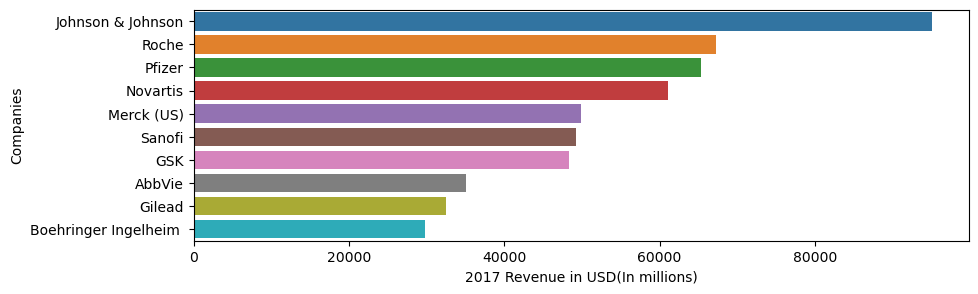

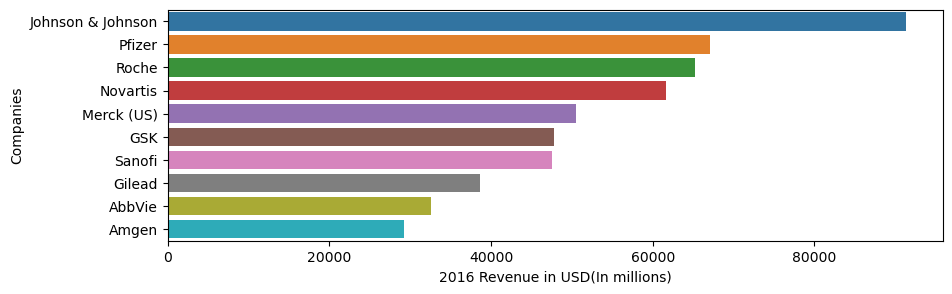

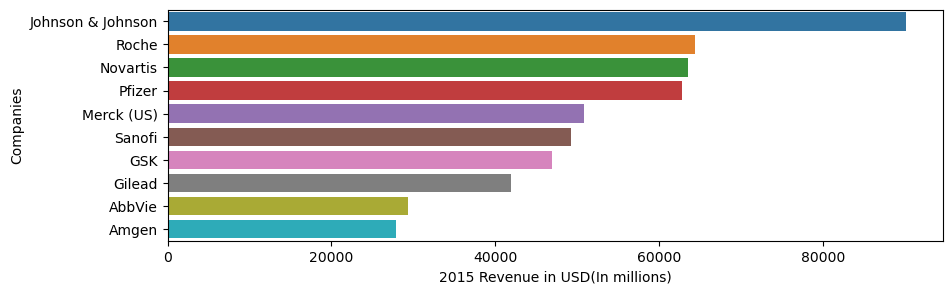

In [15]:
# lets visualize the  the top 10 companies based on revenue
def top_10(df_after_group): 
    """
    Visualizes the top 10 pharmaceutical companies based on revenue for each specified year.

    Parameters:
    df_after_group (DataFrame): DataFrame containing pharmaceutical company data, including revenue.

    Returns:
    plot: Plot of top 10 companies based on revenue.
    """  
    colums_list = ['2017 Revenue in USD', '2016 Revenue in USD', '2015 Revenue in USD']
    for colums in colums_list:
        df_top_10 = df_after_group.copy()
        df_top_10 = df_top_10.groupby(["Companies"]).sum().reset_index()
        top_10 = df_top_10.nlargest(10, colums)
        plt.figure(figsize=(10, 3))
        sns.barplot(x= colums, y='Companies', data=top_10)
        plt.xlabel(colums + "(In millions)")
    return plt
#
top_10(df_after_group)

### Result 

Johnson & Johnson emerged as the top pharmaceutical company across the three years (2015, 2016, and 2017). The majority of the top 10 companies remained consistent over the years, with the exception of Amgen, which was among the top 10 in 2015 and 2016 but dropped out in 2017. Additionally, Boehringer Ingelheim entered the top 10 list in 2017. Despite these changes, the overall composition of the top 10 companies remained largely consistent.

The function blockbuster_drug identifies the top 10 pharmaceutical companies based on their revenue in each specified year and plots the number of blockbuster drugs sold by each of these companies. 

<module 'matplotlib.pyplot' from '/Users/rahwademoz/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

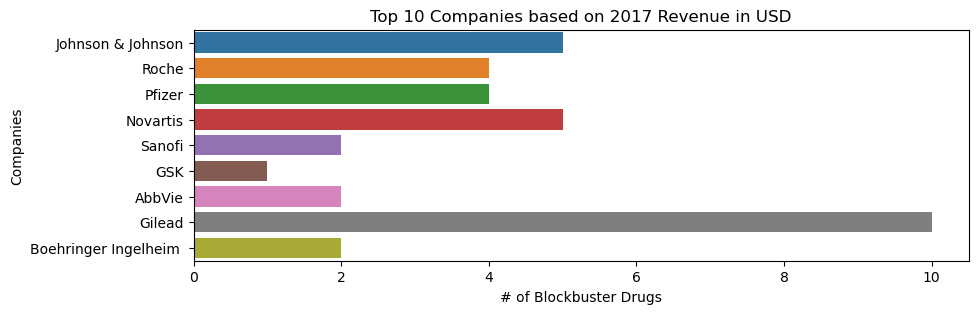

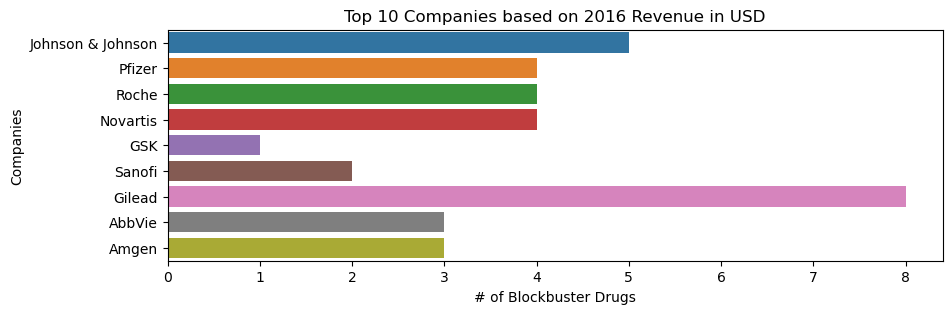

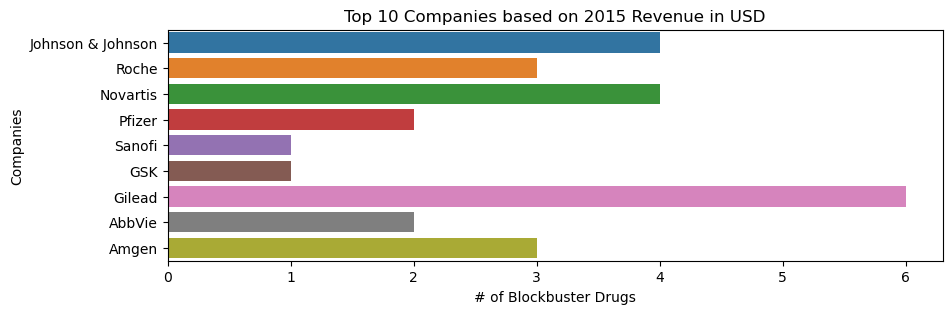

In [16]:
def blockbuster_drug(df_after_group, sales_df):
    """
    Identify top 10 pharmaceutical companies based on revenue in 
    each year and plot the number of blockbuster drugs sold by each of these companies.

    Parameters:
    df_after_group (DataFrame): DataFrame containing pharmaceutical company data including revenue and drug sales.

    Returns:
    Plot: Bar plot showing the number of blockbuster drugs sold by the top 10 pharmaceutical companies for each specified year.
    """
    
     # Make a copy of the input DataFrame to avoid modifying the original data
    df_1 = df_after_group.copy()
    df = sales_df.copy()
    
    # Define the columns related to drug sales and revenue for each year
    columns_list_2 = ['2017 Drug Sales in USD', '2016 Drug Sales in USD', '2015 Drug Sales in USD']
    columns_list = ['2017 Revenue in USD', '2016 Revenue in USD', '2015 Revenue in USD']

    
    for n, column in enumerate(columns_list_2):
        # Filter companies with drug sales above one billion dollars
        df_over_1B = df[df[column]>1000]
        
        # Count the number of blockbuster drugs sold by each company
        df_over_1B= df_over_1B.groupby(["Companies"])['INN'].count().reset_index()
        
        # Calculate the total revenue for each company
        df_top_10 = df_1.groupby(["Companies"]).sum().reset_index()
        
        # Select the top 10 companies based on revenue for the current year
        top_10 = df_top_10.nlargest(10, columns_list[n])
        
        # Merge dataframes to get the intersection of top companies and blockbuster drugs
        merge_df = pd.merge(top_10, df_over_1B,  on = 'Companies', how = 'inner')

        # Plot the number of blockbuster drugs for each 10 top company
        plt.figure(figsize=(10, 3))
        sns.barplot(x= 'INN', y='Companies', data=merge_df)
        plt.title(f"Top 10 Companies based on {columns_list[n]}")
        plt.ylabel('Companies')
        plt.xlabel("# of Blockbuster Drugs")
    return plt
blockbuster_drug(df_after_group, sales_df)

### Result

Gilead Company consistently had the highest number of blockbuster drugs every year (2015, 2016, and 2017). On the other hand, GSK had the lowest number of blockbuster drugs, with only one. Additionally, nine out of the top 10 companies had blockbuster drugs, indicating that 90% of the top 10 companies have blockbuster drugs. Interestingly, Merck (US) was consistently among the top 5 companies across all three years but did not have any blockbuster drugs.

The function blockbuster_drug_percentage visualizes the percentage of blockbuster drugs sold by the top 10 pharmaceutical companies for the years 2015, 2016, and 2017. Pie charts are generated for each company, showing the proportion of blockbuster drugs compared to other drugs

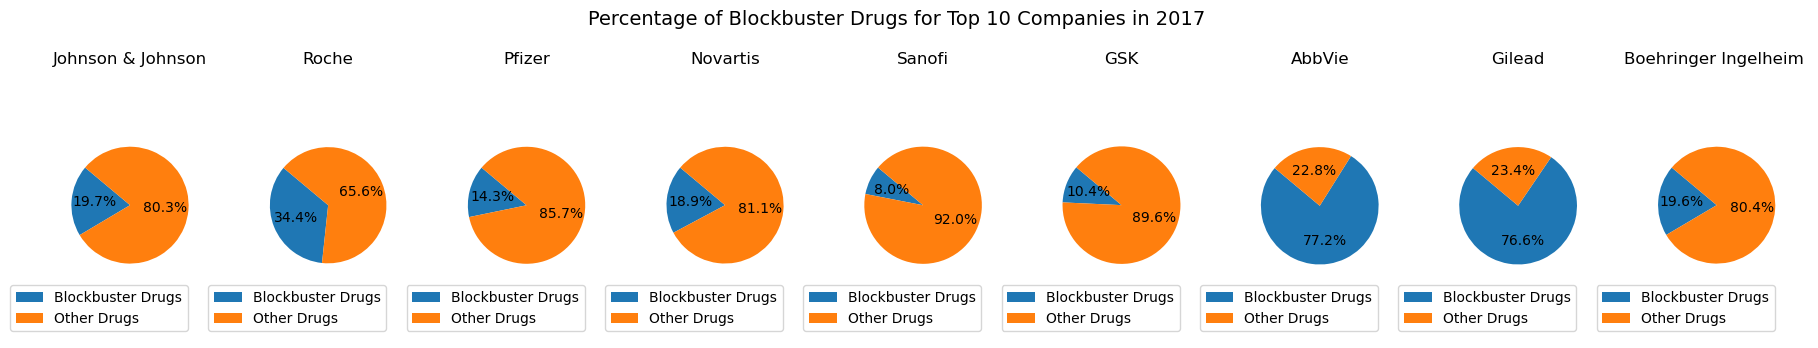

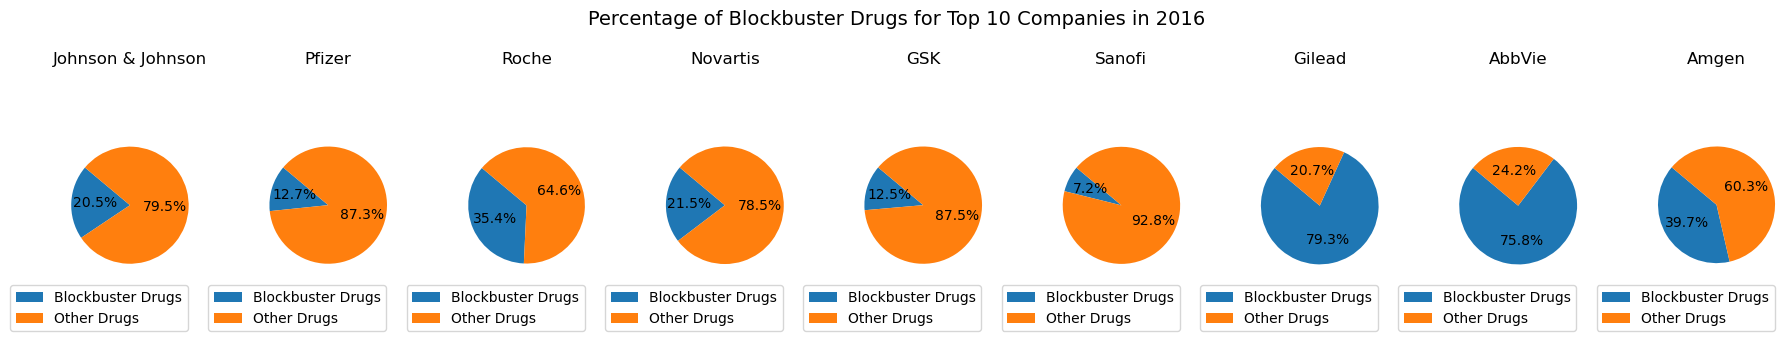

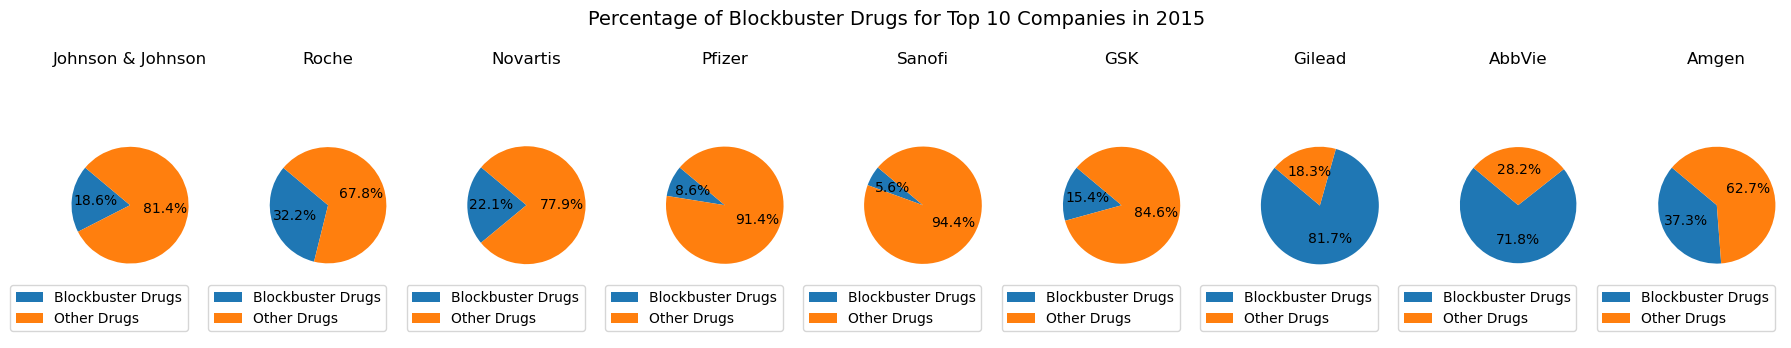

In [17]:
def blockbuster_drug_percentage(df_after_group):
    """
    Identify top 10 companies based on revenue in each year and plot the percentage 
    of blockbuster drugs sold by each of these companies in pie chart.

    Parameters:
    df_after_group (DataFrame): DataFrame containing data including revenue and drug sales.
    """
    
    # Make a copy of the input DataFrame to avoid modifying the original data
    df = df_after_group.copy()
    
    # Define the columns related to drug sales and revenue for each year
    columns_list_2 = ['2017 Drug Sales in USD', '2016 Drug Sales in USD', '2015 Drug Sales in USD']
    columns_list = ['2017 Revenue in USD', '2016 Revenue in USD', '2015 Revenue in USD']
    
    for n, column in enumerate(columns_list_2):
        # Filter companies with drug sales above one billion dollars
        df_over_1B = df[df[column] > 1000]
        
        # Count the number of blockbuster drugs sold by each company
        df_over_1B = df_over_1B.groupby(["Companies"])[column].sum().reset_index()

        # Calculate the total revenue for each company
        df_top_10 = df.groupby(["Companies"]).sum().reset_index()

        # Select the top 10 companies based on revenue for the current year
        top_10 = df_top_10.nlargest(10, columns_list[n])
        
        # Merge dataframes to get the intersection of top companies and blockbuster drugs
        merge_df = pd.merge(top_10, df_over_1B, on='Companies', how='inner')

        # Calculate the percentage of blockbuster drugs for each top company
        merge_df['% of Blockbuster Drugs of ' + str( 2017 - n) ] = merge_df[column + '_y'] / merge_df[columns_list[n]] * 100
        
        num_rows = len(merge_df)
        num_cols = 1  # Only one column to display pie charts horizontally

        # Create subplots
        fig, axes = plt.subplots(num_cols, num_rows, figsize=(18, 3.5))

        for index, row in merge_df.iterrows():
            # Extracting the percentage of blockbuster drugs for each year
            percentage_2017 = row['% of Blockbuster Drugs of ' +str(2017 - n)]
            
            # Calculating the percentage of other drugs
            percentage_other = 100 - percentage_2017
            
            # Creating the pie chart
            ax = axes[index] if num_rows > 1 else axes
            ax.pie([percentage_2017, percentage_other], labels=['', ''], autopct='%1.1f%%', startangle=140)
            ax.set_title(row['Companies'])
            ax.axis('equal')
            
            # Display the legend without labels
            ax.legend(['Blockbuster Drugs', 'Other Drugs'], loc='lower right', title=None)

        # Set a single title for all charts
        fig.suptitle('Percentage of Blockbuster Drugs for Top 10 Companies in ' + str(str(2017 - n)), fontsize=14)

        plt.tight_layout()
        plt.show()
        
blockbuster_drug_percentage(df_after_group)


### Result 

Nine out of the top 10 companies have blockbuster drugs, indicating that 90% of the top 10 companies in the pharmaceutical industry possess blockbuster medications. The pie charts illustrate that except for Gilead and AbbVie, the contribution of blockbuster drugs is less than 50%. However, for both Gilead and AbbVie, the blockbuster drugs constitute a significant portion, with revenues exceeding 70%.

This code block will investigate the whether having blockbuster drug suggests higher revenue. The blockbuster drugs will be identified in every year between 2015 to 2017, and the corresponding revenue of the companies with or without blockbuster drugs will be compared in each year using boxplot and student's t-test.

t-value and p-value in 2015 are: 1.8048709672901664 0.08696909542711323
t-value and p-value in 2016 are: 0.49253803826769305 0.6279824139948935
t-value and p-value in 2017 are: -0.014568812640147765 0.9885280755924293


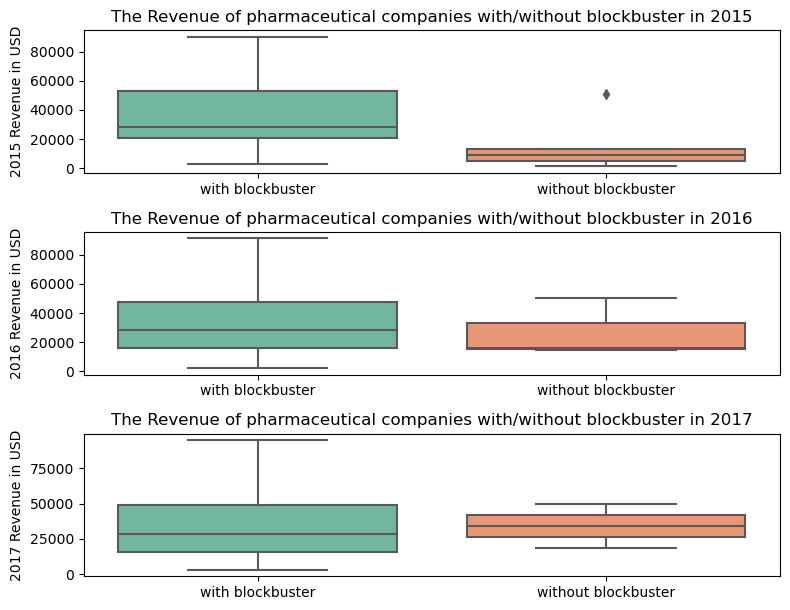

In [18]:
# Build the mask for blockbuster screen
def blockbuster_sale_revenue(df_after_group, sales_df):
    
    """
    Compare the overall revenue of the companies with/without blockbuster drugs via box chart and student's t-test.

    Parameters:
    df_after_group (DataFrame): DataFrame containing data including revenue and drug sales.  

    Return:
    None
    """
    
    # Create plot
    fig, axes = plt.subplots(3, 1, figsize=(8, 6.2))
    n=0
    
    for year in [2015, 2016, 2017]:
        
        # Set up DataFrame of blockbuster drugs and non-blockbuster drugs
        mask = (sales_df[f'{year} Drug Sales in USD']>1000)
        df_is_blockbuster = sales_df.loc[mask]
        df_is_not_blockbuster = sales_df.loc[~mask]
        
        # Build the DataFrame of the revenue with blockbusters and without blockbusters
        mask_with_blockbuster = df_after_group["Companies"].isin(df_is_blockbuster["Companies"].unique())
        df_with_blockbuster_revenue = df_after_group.loc[mask_with_blockbuster].copy()
        df_without_blockbuster_revenue =df_after_group.loc[~mask_with_blockbuster].copy()
        
        # Label the companies as "with blockbuster" and "without blockbuster"
        df_with_blockbuster_revenue.loc[:,"blockbuster"] = "with blockbuster"
        df_without_blockbuster_revenue.loc[:,"blockbuster"] = "without blockbuster"
        df = pd.concat([df_with_blockbuster_revenue,df_without_blockbuster_revenue])
        
        sns.boxplot(data=df, x= "blockbuster", y = f'{year} Revenue in USD',palette="Set2",ax=axes[n])
        axes[n].set_title(f'The Revenue of pharmaceutical companies with/without blockbuster in {year}')
        axes[n].set_xlabel(None)
        
        plt.tight_layout()
        n+=1

        t_val, p_val = ttest_ind(df_with_blockbuster_revenue[f"{year} Revenue in USD"],
                                   df_without_blockbuster_revenue[f"{year} Revenue in USD"])
        
        print(f"t-value and p-value in {year} are:", t_val, p_val)
        
    # Next, make a new df that has a column labeling "blockbuster" and "Non-blockbuster"
    
    # Only the company names, year revenue
blockbuster_sale_revenue(df_after_group, sales_df)  


### Result

The statistical analysis using the t-value indicates that there was no significant difference in revenue between companies with and without blockbuster drugs in 2016 and 2017. However, in 2015, a significant difference was observed, suggesting that companies with blockbuster drugs had higher revenue compared to those without.

The blockbuster_research_development function analyzes the influence of blockbuster drugs on research and development (R&D) investment in pharmaceutical companies for the years 2015, 2016, and 2017. It compares R&D expenditures between companies with and without blockbuster drugs, examining both absolute R&D costs and R&D expenditure as a share of revenue.

t-value and p-value of net R&D cost in 2015 are: 1.8311317394526705 0.08280951333294578
t-value and p-value of R&D as share of revenue (%) in 2015 are: -2.1507337681151166 0.04457922438609519
t-value and p-value of net R&D cost in 2016 are: 0.16317809167980166 0.8721013372899561
t-value and p-value of R&D as share of revenue (%) in 2016 are: 0.6254045605251677 0.539145527162758
t-value and p-value of net R&D cost in 2017 are: -0.4116428812194521 0.6852077253159647
t-value and p-value of R&D as share of revenue (%) in 2017 are: 0.43623340790592424 0.6675839218529778


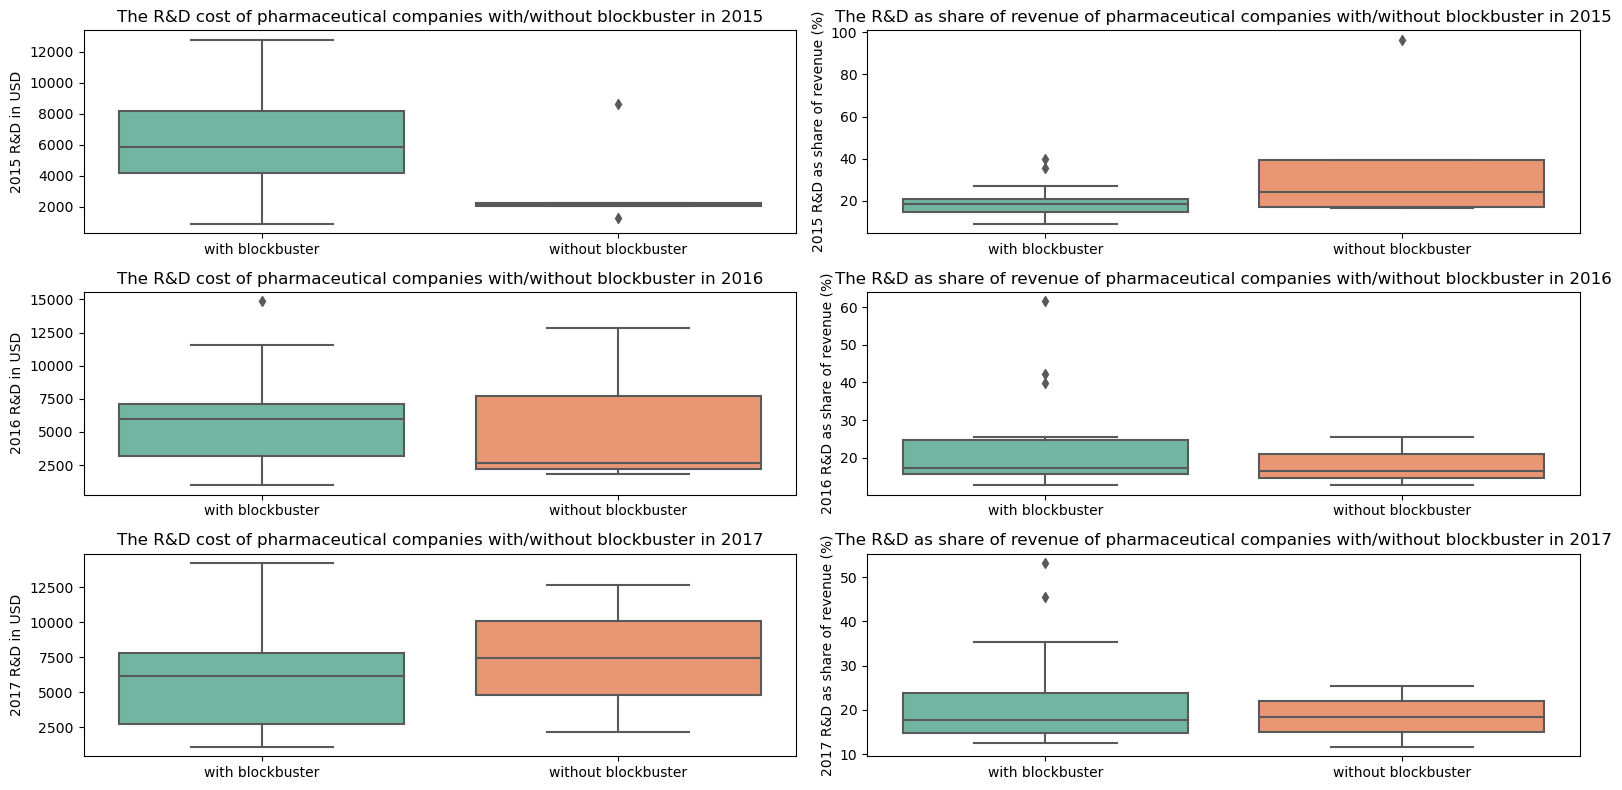

In [19]:
def blockbuster_research_development(df_after_group, sales_df):

    """The blockbuster identification is almost the same as in the function blockbuster_sale_revenue"""
    
    # Create plot
    fig, axes = plt.subplots(3, 2, figsize=(16, 8))
    col=0

    for i, year in enumerate([2015, 2016, 2017]):
        row = i 
        
        # Set up DataFrame of blockbuster drugs and non-blockbuster drugs
        mask = (sales_df[f'{year} Drug Sales in USD']>1000)
        df_is_blockbuster = sales_df.loc[mask]
        df_is_not_blockbuster = sales_df.loc[~mask]
        
        # Build the DataFrame of the revenue with blockbusters and without blockbusters
        mask_with_blockbuster = df_after_group["Companies"].isin(df_is_blockbuster["Companies"].unique())
        df_with_blockbuster_R_and_D = df_after_group.loc[mask_with_blockbuster].copy()
        df_without_blockbuster_R_and_D =df_after_group.loc[~mask_with_blockbuster].copy()
        
        # Label the companies as "with blockbuster" and "without blockbuster"
        df_with_blockbuster_R_and_D.loc[:,"blockbuster"] = "with blockbuster"
        df_without_blockbuster_R_and_D.loc[:,"blockbuster"] = "without blockbuster"
        df = pd.concat([df_with_blockbuster_R_and_D,df_without_blockbuster_R_and_D])
        
        # Net R&D
        sns.boxplot(data=df, x= "blockbuster", y = f'{year} R&D in USD',palette="Set2",ax=axes[row,col])
        axes[row,col].set_title(f'The R&D cost of pharmaceutical companies with/without blockbuster in {year}')
        axes[row,col].set_xlabel(None)
        col=1

        t_val, p_val = ttest_ind(df_with_blockbuster_R_and_D[f"{year} R&D in USD"],
                                   df_without_blockbuster_R_and_D[f"{year} R&D in USD"])
        
        print(f"t-value and p-value of net R&D cost in {year} are:", t_val, p_val)
        
        # R%D share
        sns.boxplot(data=df, x= "blockbuster", y = f'{year} R&D as share of revenue (%)',palette="Set2",ax=axes[row,col])
        axes[row,col].set_title(f'The R&D as share of revenue of pharmaceutical companies with/without blockbuster in {year}')
        axes[row,col].set_xlabel(None)
        col=0
                       
        t_val, p_val = ttest_ind(df_with_blockbuster_R_and_D[f"{year} R&D as share of revenue (%)"],
                                   df_without_blockbuster_R_and_D[f"{year} R&D as share of revenue (%)"])
        
        print(f"t-value and p-value of R&D as share of revenue (%) in {year} are:", t_val, p_val)
        
        plt.tight_layout()

blockbuster_research_development(df_after_group, sales_df)


### Result

The statistical analysis using the t-value indicates that there was no significant difference in research and development (R&D) investment between pharmaceutical companies with and without blockbuster drugs in 2016 and 2017. However, a significant difference was observed in 2015, suggesting that companies with blockbuster drugs had higher R&D investment compared to those without.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4819c6bc-99ec-492b-8bfe-481fe7b005c4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>